## 2024.10.24 - Generative AI | Homework 1 Assignment
In this exercise, you will implement a static (i.e. not learned) Embedding Layer and the Positional Encoding Layer.\
Base your code on the skeleton code that we provide.

Passages, where you should add your implementation, are marked with

\# YOUR CODE HERE</br>
raise NotImplementedError()


Each of the two tasks has a maximum of 0,5 points.

### Task 1 -  Embedding Layer (0,5p):
Implement a static embedding layer. This layer should be able to:
- Look up and return embeddings for a given list of token IDs.
- Handle potential out-of-bounds errors when looking up embeddings.

In [1]:
import math
from typing import List
import torch
from torch import Tensor
import numpy as np

In [2]:
class Embedding:
    def __init__(self, n_embd: int, d_embd: int):
        """
        A simple embedding layer that maps token indices to dense vectors.

        Args:
            n_embd (int): Number of embeddings (vocabulary size)
            d_embd (int): Dimensionality of each embedding vector
        """
        torch.manual_seed(42)
        self.lookup = torch.randn(n_embd, d_embd)

    def forward(self, input: Tensor) -> Tensor:
        """
        Maps token indices to their corresponding embedding vectors.
        
        This operation is essentially a lookup or indexing operation where each input token ID
        is replaced by its corresponding vector from the embedding table.
        
        Args:
            input (Tensor): An unidimensional tensor of token indices each value should be in range [0, n_embd-1]
        
        Returns:
            Tensor: The embedding vectors for each input token
                    Shape: (sequence_length, d_embd)
        
        Raises:
            ValueError: If any input index is out of bounds of the embedding table
        """
        # YOUR CODE HERE
        return self.lookup[input]

    def __call__(self, input: Tensor) -> Tensor:
        # This function lets you call a class instance as a function e.g. Embedding(n_embd, d_emdb)(x)
        # https://docs.python.org/3/reference/datamodel.html#object.__call__
        return self.forward(input)

In [3]:
class Tokenizer:
    def __init__(self, vocab: List[str]):
        self.vocab = vocab
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for idx, token in enumerate(vocab)}

    def parse(self, input: str) -> List[str]:
        """Tokenkize a string to a list of whitespace-separated substrings."""
        return input.split(' ')

    def encode(self, tokens: List[str]) -> List[int]:
        """Encode a list of tokens into their corresponding indices."""
        return [self.token2idx.get(token, self.token2idx.get('<unk>', None)) for token in tokens]

    def decode(self, indices: List[int]) -> str:
        """Decode a list of indices back into a string."""
        return ' '.join([self.idx2token.get(idx, '<unk>') for idx in indices])    

In [4]:
def assert_raises(fn, *args, **kwargs):
    # A helper function to assert a function call throws an exception
    try:
        fn(*args, **kwargs)
    except Exception as e:
        print(f"✅ Expected error occurred: {type(e).__name__} - {e}")
        return
    raise AssertionError("Expected error did not occur")

#### Task 1 - Verification

Use the cell below to test your implementation. You can expect to gain the full score on this exercise if assertions pass.

In [5]:
"""
Expected Output:

============ Embedding Layer
input (torch.Size([8])):
tensor([ 1, 13,  2,  5,  6,  1, 14,  3])

embedding_layer result (torch.Size([8, 3])):
tensor([[-2.1055,  0.6784, -1.2345],
        [-1.2862, -1.4032,  0.0360],
        [-0.0431, -1.6047, -0.7521],
        [ 0.7624,  1.6423, -0.1596],
        [-0.4974,  0.4396, -0.7581],
        [-2.1055,  0.6784, -1.2345],
        [-0.0635,  0.6756, -0.0978],
        [ 1.6487, -0.3925, -1.4036]])
Expected error occurred: ValueError - Input tensor contains invalid indices for lookup table.
"""
print("============ Embedding Layer")

vocab = ["<unk>", "the", "dog", "cat", "runs", "jumps", "over", "and",
         "sleeps", "eats", "food", "fast", "slow", "big", "small"]
tokenizer = Tokenizer(vocab)
n_embd = len(vocab)
d_embd = 3
embedding_layer = Embedding(n_embd, d_embd)

input_sequence = "the big dog jumps over the small cat"
input_id_sequence = tokenizer.encode(tokenizer.parse(input_sequence))
input_tensor = torch.tensor(input_id_sequence)

embeddings = embedding_layer(input_tensor)

print(f"input ({input_tensor.size()}):\n{input_tensor}\n")
print(f"embedding_layer result ({embeddings.size()}):\n{embeddings}")

# Assure layer throws exception on invalid index
assert_raises(embedding_layer, torch.tensor([n_embd]))

# Assert embeddings are as expected
expected = torch.tensor([[-2.1055,  0.6784, -1.2345],
        [-1.2862, -1.4032,  0.0360],
        [-0.0431, -1.6047, -0.7521],
        [ 0.7624,  1.6423, -0.1596],
        [-0.4974,  0.4396, -0.7581],
        [-2.1055,  0.6784, -1.2345],
        [-0.0635,  0.6756, -0.0978],
        [ 1.6487, -0.3925, -1.4036]], dtype=embeddings.dtype)
assert torch.allclose(expected, embeddings, atol=1e-4)

print("\nLooks good ✅!\n")

============ Embedding Layer
input (torch.Size([8])):
tensor([ 1, 13,  2,  5,  6,  1, 14,  3])

embedding_layer result (torch.Size([8, 3])):
tensor([[-2.1055,  0.6784, -1.2345],
        [-1.2862, -1.4032,  0.0360],
        [-0.0431, -1.6047, -0.7521],
        [ 0.7624,  1.6423, -0.1596],
        [-0.4974,  0.4396, -0.7581],
        [-2.1055,  0.6784, -1.2345],
        [-0.0635,  0.6756, -0.0978],
        [ 1.6487, -0.3925, -1.4036]])
✅ Expected error occurred: IndexError - index 15 is out of bounds for dimension 0 with size 15

Looks good ✅!



### Task 2 - Positional Encoding (0,5p):
Implement the sinusoidal positional encoding as described in the lecture.
The positional encoding should:
- Generate position encodings for sequences up to a maximum length
- Use sine and cosine functions of different frequencies
- Have the same dimensionality as the embeddings
- Be added to the embeddings to create position-aware representations

The positional encoding can be implemented mainly in two ways:

1. Loop-based approach:
   - Loop through each position and dimension
   - For each position pos and dimension i:
     * Even dimensions use sine: PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
     * Odd dimensions use cosine: PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
2. Vectorized approach (more efficient):
   - Create position vector: [0, 1, 2, ...] and reshape to (max_len, 1)
   - Create division terms for even dimensions: 10000^(2i/d_model)
   - Use broadcasting to compute all positions at once:
     position_vector / div_terms -> gives all frequency terms
   - Assign to even/odd indices using stride slicing (:, 0::2 and :, 1::2)

In [6]:
class PositionalEncoding:
    def __init__(self, d_model: int, max_len: int = 10):
        """
        Initialize the positional encoding matrix.
        The matrix should encode position information using sine and cosine functions.
        """
        
        self.pe = torch.zeros(max_len, d_model)        
        # IMPLEMENT THE POSITIONAL ENCODING HERE
        # Use the formula from the "Attention Is All You Need" paper:
        # PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
        # PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        #
        # Important: Ensure that the final position encoding matrix is assigned to self.pe

        # YOUR CODE HERE
        position_vector = torch.arange(max_len, dtype=torch.float).reshape(max_len, 1)
        
        # Create division terms for even dimensions: 10000^(2i/d_model)
        div_terms = 10000 ** (torch.arange(0, d_model, 2, dtype=torch.float) / d_model)
        
        # Compute all frequency terms using broadcasting
        # This gives us the frequency for each position and dimension
        freq_terms = position_vector / div_terms
        
        # Assign to even/odd indices using stride slicing
        self.pe = torch.zeros(max_len, d_model)
        self.pe[:, 0::2] = torch.sin(freq_terms)  # even indices
        self.pe[:, 1::2] = torch.cos(freq_terms)  # odd indices
        
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Add positional encodings to the input embeddings.
        
        Args:
            x: Input embeddings tensor of shape (sequence_length, d_model)
        
        Returns:
            Input embeddings with positional encoding added
        """
        # Get the length of the input sequence
        seq_len = x.size(0)
        
        # Add positional encodings to the input embeddings
        # We only use as many positions as we have tokens in the sequence
        return x + self.pe[:seq_len, :]

    def __call__(self, x: Tensor) -> Tensor:
        return self.forward(x)

Look at the plot below - it should look similar to what you have seen on the slide.

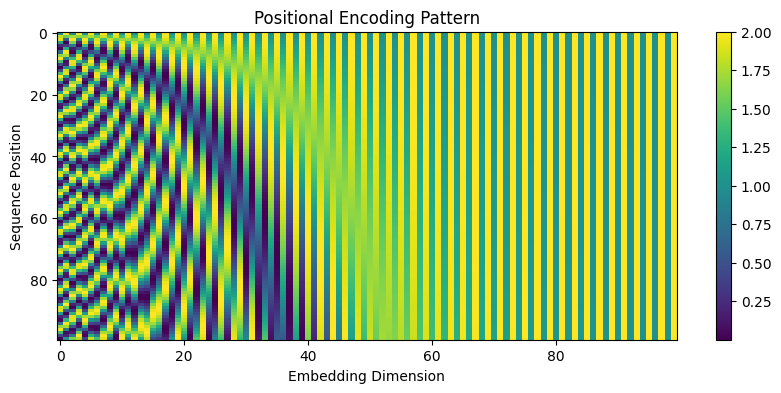

In [7]:
import matplotlib.pyplot as plt

seq_length = 100
d_model = 100
x = torch.ones(seq_length, d_model)

pe = PositionalEncoding(d_model, seq_length)
encoded = pe(x)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(encoded.detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Position')
plt.title('Positional Encoding Pattern')
plt.show()

#### Task 2 - Verification

Use the cell below to test your implementation. You can expect to gain the full score on this exercise if assertions pass.

In [8]:
print("============ Positional Encoding")
d_model, max_len = 4, 3
pe = PositionalEncoding(d_model, max_len)

##### TEST CASE 1
print("Validating shape of result ...")
assert pe.pe.shape == (max_len, d_model), f"Expected shape ({max_len}, {d_model}), got {pe.pe.shape}"

##### TEST CASE 2
print("Validating known values for small input ...")
expected_pe = torch.tensor([
    [ 0.0000,  1.0000,  0.0000,  1.0000],
    [ 0.8415,  0.5403,  0.0100,  1.0000],
    [ 0.9093, -0.4161,  0.0200,  0.9998]
], dtype=torch.float32)

assert torch.allclose(pe.pe, expected_pe, atol=1e-4), \
    f"Expected:\n{expected_pe}\nGot:\n{pe.pe}"

##### TEST CASE 3
print("Validating forward pass with embeddings ...")
embeddings = torch.ones(2, d_model)
output = pe(embeddings)
expected_output = embeddings + expected_pe[:2]  # Only first 2 positions
assert torch.allclose(output, expected_output, atol=1e-4), \
    f"Forward pass failed. Expected:\n{expected_output}\nGot:\n{output}"

##### TEST CASE 4
print("Validating properties that should hold for any valid implementation ...")
pe_large = PositionalEncoding(d_model=8, max_len=5)

# Even indices should use sine, odd indices should use cosine
# Test first position (pos=0)
assert torch.allclose(pe_large.pe[0, 0::2], torch.zeros(4), atol=1e-6), \
    "First position should have zeros for sine components"
assert torch.allclose(pe_large.pe[0, 1::2], torch.ones(4), atol=1e-6), \
    "First position should have ones for cosine components"

# Test that frequencies decrease with dimension
# Compare amplitudes of changes between positions for different dimensions
changes = torch.abs(pe_large.pe[1:] - pe_large.pe[:-1])  # Position-wise changes
for i in range(0, d_model-2, 2):
    assert torch.mean(changes[:, i]) > torch.mean(changes[:, i+2]), \
        f"Frequency should decrease with dimension. Error at dimension {i}"

print("\nLooks good ✅!\n")

============ Positional Encoding
Validating shape of result ...
Validating known values for small input ...
Validating forward pass with embeddings ...
Validating properties that should hold for any valid implementation ...

Looks good ✅!

